In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")



from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,accuracy_score,confusion_matrix
from sklearn.feature_selection import mutual_info_classif

from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB

from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression 
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error,r2_score



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

from tensorflow.keras.optimizers import Adam

In [235]:
pd.pandas.set_option("display.max_columns",None)
pd.pandas.set_option("display.max_rows",None)
data = pd.read_excel('Data.xlsx')
flight_dates = pd.read_excel('Data.xlsx',sheet_name = 1)
planting = pd.read_excel('Data.xlsx',sheet_name = 2)
weather = pd.read_excel('Data.xlsx',sheet_name = 3)

# Weather Data

In [236]:
new_weather= weather.copy()


In [237]:
new_weather= new_weather.drop(["Wind Speed [max]","Air Temperature [min]","Air Temperature [max]","Dew Point [min]"],axis=1)


We are only interested in average values as we are planning to take average weather data from plant_date to check_date

In [238]:
new_weather= new_weather.drop(["Battery Voltage [last]","Unnamed: 0"],axis=1)
# Battery voltage doesnt make any sense 

In [239]:
new_weather["Dew Point [avg]"] = new_weather["Dew Point [avg]"].fillna(new_weather["Dew Point [avg]"].mean())
# mean imputing

In [240]:
ET0_prediction = new_weather.query("`ET0 [result]` != `ET0 [result]`")
# lets copy the rows were ET0 is nan

The plan is to train a model using exixting data to predict ET0

In [241]:
new_weather=pd.concat([new_weather, ET0_prediction, ET0_prediction]).drop_duplicates(keep=False)
x=new_weather.drop(["ET0 [result]"],axis=1)
y=new_weather["ET0 [result]"]
x_data,x_validation,y_data,y_validation = train_test_split(x,y, train_size=0.9, random_state=10)# test train split

In [242]:
from scipy.stats import skew # this will give us the skewness score of the data
normal_distribution=[] 
skewed_distribution=[]

for i in x_data:
    print("skewness of",i,"=",skew(x_data[i])) # we will know how much the data is skewed
    #sns.set(rc={'figure.figsize':(11.7,8.27)})
    #sns.distplot(x_data[i]) # we are plotting a graph of the distribution
    #plt.show()
    if skew(x_data[i])>-0.5 and skew(x_data[i])<0.5: # if the skewness score is closer to 0 we know that its a normal distribution
        normal_distribution.append(i) # the features with normal distribution will be stored in this list
    else:
        skewed_distribution.append(i) # the features with skewed distribution will be stored here
        
        
for i in skewed_distribution:
    IQR=x_data[i].quantile(0.75)-x_data[i].quantile(0.25) # for features with skewed distribution the Inter Ouartile Range should be found
    
    lowerbridge=x_data[i].quantile(0.25)-(3*IQR) # the lower bridge should be determined using this equation
    upperbridge=x_data[i].quantile(0.75)+(3*IQR) # the upper bridge can be determined here
    
    x_data.loc[x_data[i]<=lowerbridge,i]=lowerbridge # if the value is less than lower bridge, it is capped with the lower bridge value
    x_data.loc[x_data[i]>=upperbridge,i]=upperbridge # similarly if the value is greater than upper bridge , it is cappef
    
for i in normal_distribution:
    upper_boundary=x_data[i].mean() + 3* x_data[i].std() # # the upper boundary can be determined by this equation for normal_distribution
    lower_boundary=x_data[i].mean() - 3* x_data[i].std() # lower boundary is determined
    x_data.loc[x_data[i]<=lower_boundary,i]=lower_boundary # lower boundary capping
    x_data.loc[x_data[i]>=upper_boundary,i]=upper_boundary # upper boundary capping
    
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data, train_size=0.7, random_state=42)
print("++++++++++++++++++++ Data Splitting +++++++++++++++++++++++")
print("\n\tSplit Ratio (Train : Test): {}% : {}%\n".format(70,30))
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("\n\t      Records under Train Set: {}".format(len(x_train)))
print("\n\t      Records under Test Set: {}\n".format(len(x_test)))
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

Algorithms=[
    LinearRegression(fit_intercept=False),
    RandomForestRegressor(n_estimators= 775, random_state=67,max_features='log2',bootstrap=False),
    MLPRegressor(hidden_layer_sizes=(100,100,100,100,100,),activation="logistic",max_iter=2000),
    
]  # we are trying to use 3 regression algorithms here


Names=["Linear Regression","Random Forest Regressor","MLP Regressor"]

mean_square={} # the metrics that we are going to use is mean_square and r2_value
r2_value={}
for i in range(len(Algorithms)):
    print("\n_______________________________________________\n")
    print("                        ",Names[i])
    print("\n_______________________________________________\n")
    
    Algorithms[i].fit(x_train, y_train)
    y_pred=Algorithms[i].predict(x_test)
    
    mse=mean_squared_error(y_test,y_pred)
    r2=r2_score(y_test,y_pred)
    
    print("\nMean Squared error=",mse*100)
    print("\nr2 score=",r2*100)
    
    mean_square[Names[i]]=mse
    r2_value[Names[i]]=r2

skewness of Solar Radiation [avg] = 0.7549254306520592
skewness of Precipitation [sum] = 11.449506305566095
skewness of Wind Speed [avg] = 0.9614819912220144
skewness of Leaf Wetness [time] = 1.9529101139582574
skewness of Air Temperature [avg] = 0.04301733859300427
skewness of Relative Humidity [avg] = -1.4834179929017803
skewness of Dew Point [avg] = 0.003942791360398962
++++++++++++++++++++ Data Splitting +++++++++++++++++++++++

	Split Ratio (Train : Test): 70% : 30%

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

	      Records under Train Set: 1568

	      Records under Test Set: 673

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

_______________________________________________

                         Linear Regression

_______________________________________________


Mean Squared error= 14.186928249328556

r2 score= 92.4538902467517

_______________________________________________

                         Random Forest Regressor

_________________

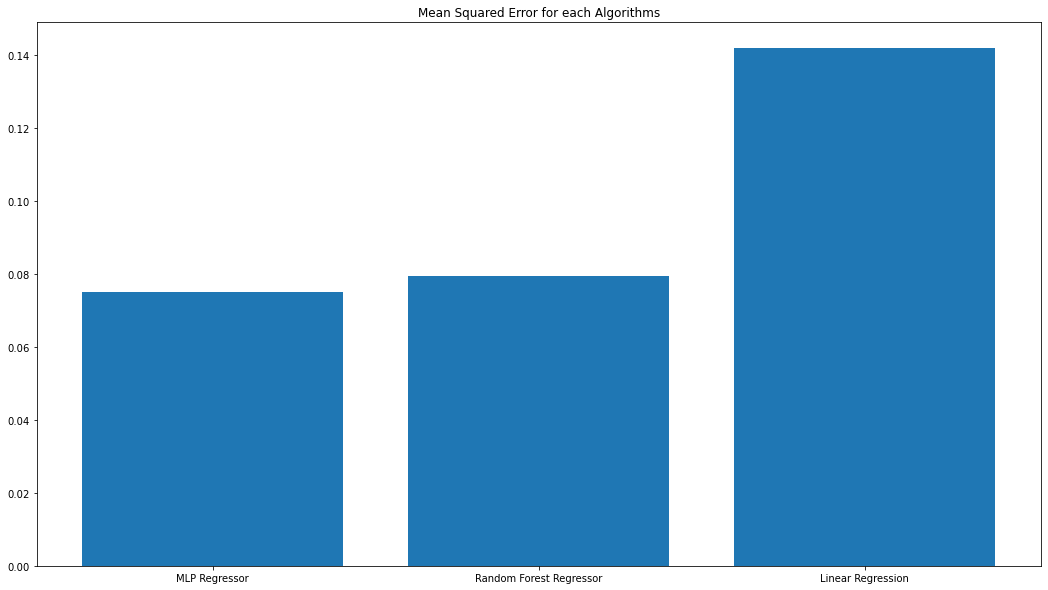

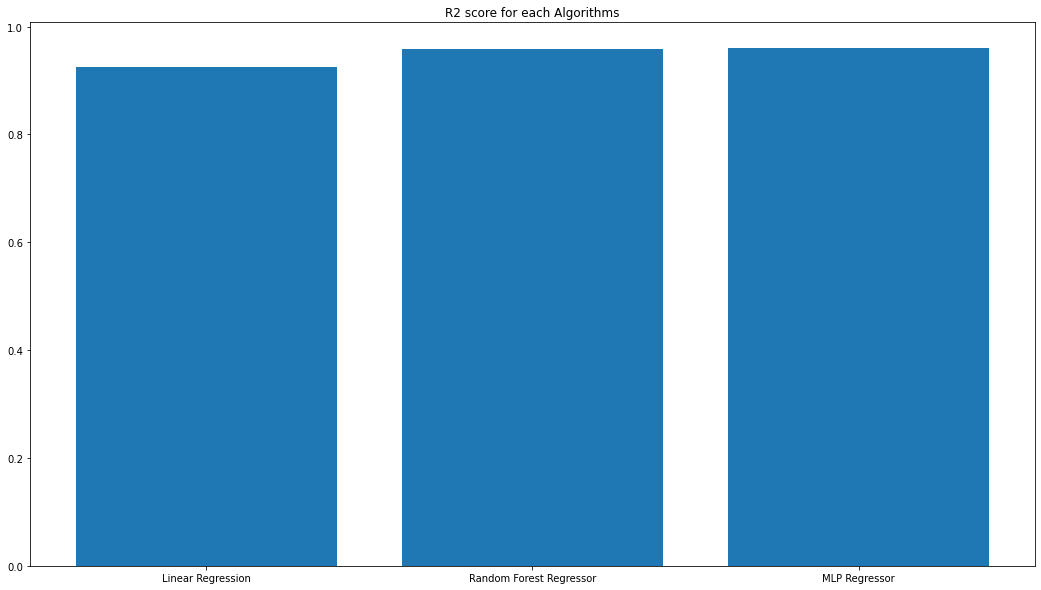

MLP Regressor
MLPRegressor(activation='logistic',
             hidden_layer_sizes=(100, 100, 100, 100, 100), max_iter=2000)


In [243]:
sorted_values = sorted(mean_square.values()) # Sort the values
sorted_mse_dict = {}

for i in sorted_values:
    for k in mean_square.keys():
        if mean_square[k] == i:
            sorted_mse_dict[k] = mean_square[k]
            break
mean_square=sorted_mse_dict
names = list(mean_square.keys())
values = list(mean_square.values())

plt.figure(figsize=(18,10))
plt.title("Mean Squared Error for each Algorithms")
plt.bar(range(len(mean_square)), values, tick_label=names)
plt.show()

# lets try to visualise the algorithms based on their mse values


sorted_values = sorted(r2_value.values()) # Sort the values
sorted_r2_dict = {}

for i in sorted_values:
    for k in r2_value.keys():
        if r2_value[k] == i:
            sorted_r2_dict[k] = r2_value[k]
            break
r2_value=sorted_r2_dict
names = list(r2_value.keys())
values = list(r2_value.values())

plt.figure(figsize=(18,10))
plt.title("R2 score for each Algorithms")
plt.bar(range(len(r2_value)), values, tick_label=names)
plt.show()


Best_Algorithm = max(r2_value, key=r2_value.get)
print(Best_Algorithm)
Best_Model=Algorithms[Names.index(Best_Algorithm)]
print(Best_Model)


x_validation["Predicted ET0"]= Best_Model.predict(x_validation).reshape(-1,1)
mean_squared_error(y_validation,x_validation["Predicted ET0"])
r2_score(y_validation,x_validation["Predicted ET0"])
ET0_prediction["ET0 [result]"]= Best_Model.predict(ET0_prediction.drop(["ET0 [result]"], axis = 1)).reshape(-1,1)
for i,row in ET0_prediction.iterrows():
    
    new_weather.loc[i] = row

In [11]:
weather["ET0 [result]"] = new_weather["ET0 [result]"]
weather["Dew Point [avg]"] = new_weather["Dew Point [avg]"]
weather["Dew Point [min]"] = weather["Dew Point [min]"].fillna(weather["Dew Point [min]"].mean())
# adding the new ET0 value to weather data

In [12]:
weather = weather.rename(columns={"Unnamed: 0":'Date'})
weather.drop(["Wind Speed [max]","Air Temperature [min]","Air Temperature [max]","Dew Point [min]","Battery Voltage [last]"],axis=1,inplace=True)
weather.drop_duplicates(subset ="Date",keep = "last", inplace = True)
weather=weather.reset_index(drop=True)

In [14]:
idx = pd.date_range('2014-05-14', '2021-05-20')

weather = weather.set_index("Date")


weather = weather.reindex(idx)


# There were some missing dates in th weather data, we have to fill them up.

#https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe

In [15]:
weather.reset_index(inplace=True)
weather = weather.rename(columns = {'index':'Date'})

In [17]:
weather.ffill(inplace=True) # the new rows are imputed with the weather from next available date.

In [19]:
processing = weather.copy()

In [20]:
processing = processing.set_index("Date")

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

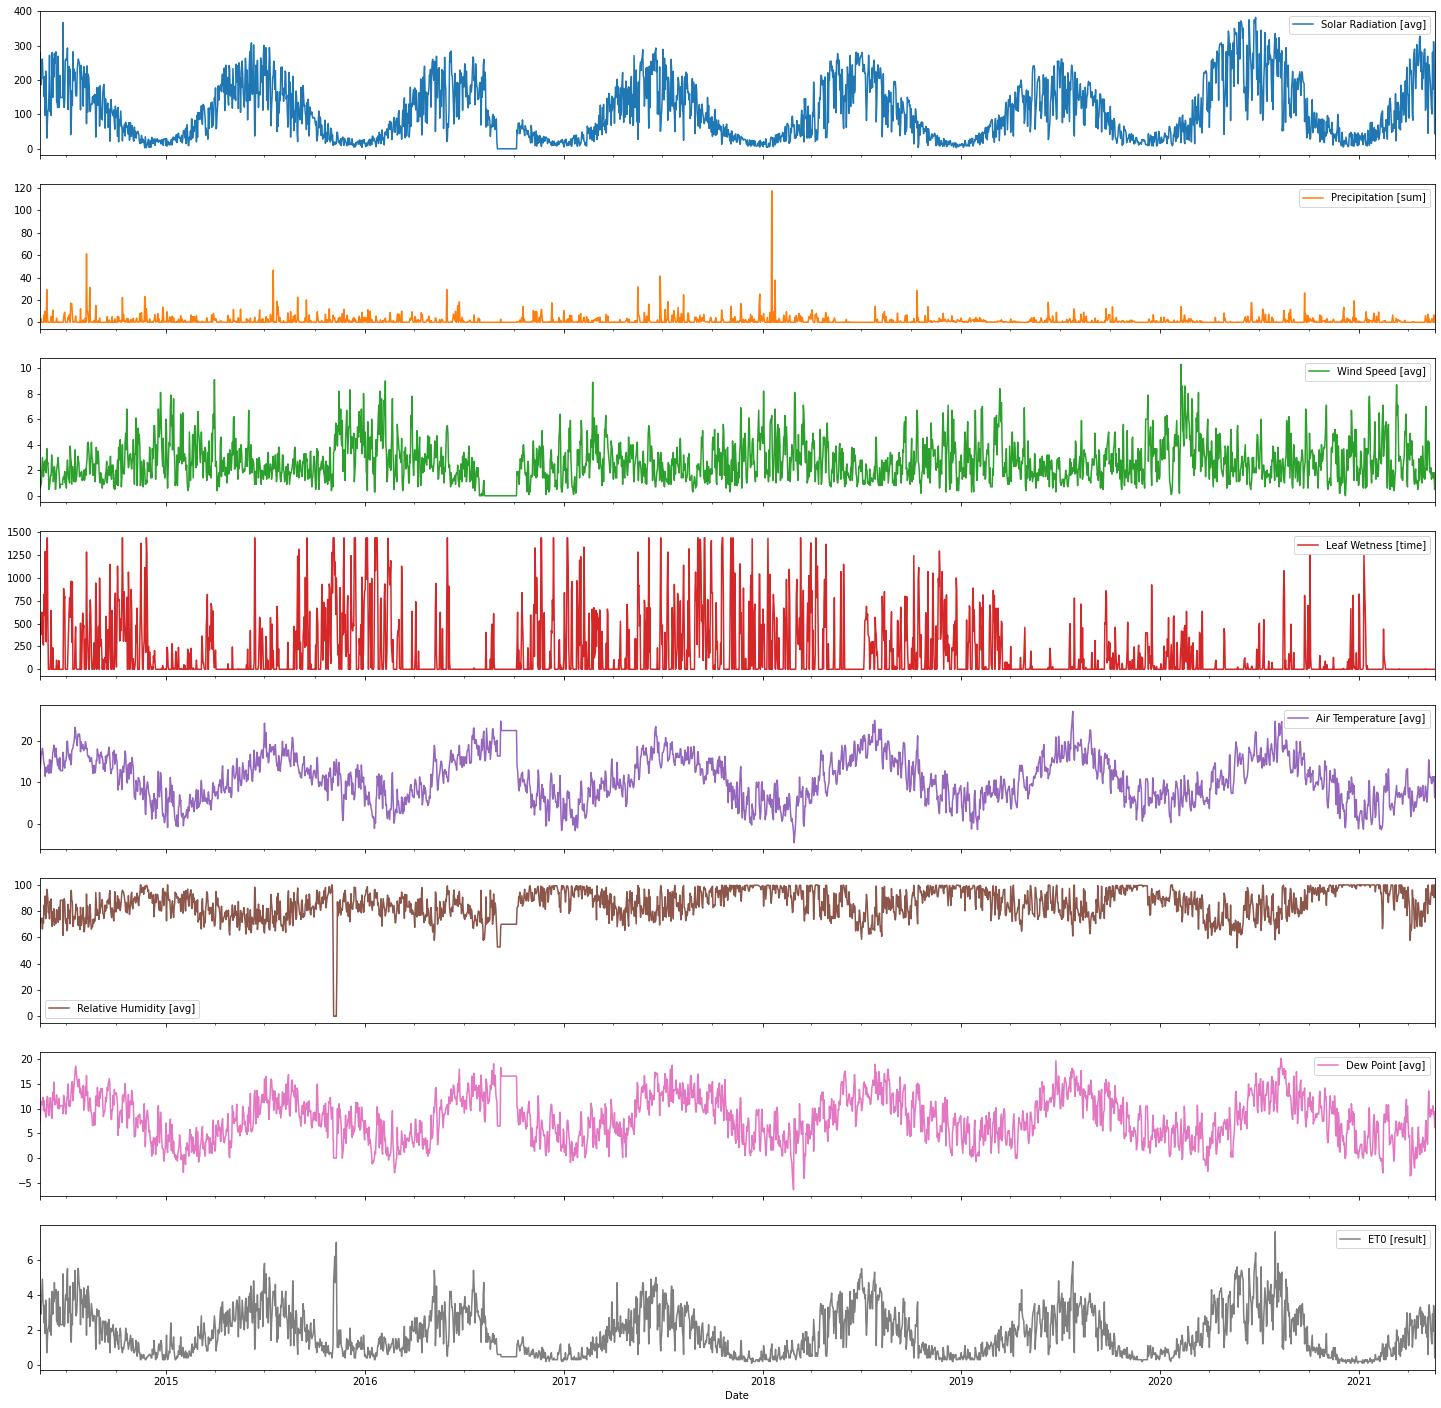

In [21]:

processing.plot(subplots=True,figsize=(25,25))

In [22]:
processing.drop(["Solar Radiation [avg]","Leaf Wetness [time]","Precipitation [sum]"],axis=1,inplace=True)

when the the model was run , these three values didnt give accurate predictions, so removing them here

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))


scaled = scaler.fit_transform(processing)

scaled

array([[0.13592233, 0.59334798, 0.6495    , 0.5037594 , 0.39573763],
       [0.05825243, 0.5695011 , 0.7291    , 0.52631579, 0.46666667],
       [0.0776699 , 0.63664889, 0.7469    , 0.63533835, 0.37333333],
       ...,
       [0.13592233, 0.46846564, 0.9294    , 0.57142857, 0.44      ],
       [0.17475728, 0.50298086, 0.9032    , 0.59398496, 0.38666667],
       [0.04854369, 0.34483841, 0.9986    , 0.47368421, 0.04201082]])

In [24]:
processing[["Wind Speed [avg]","Air Temperature [avg]","Relative Humidity [avg]","Dew Point [avg]","ET0 [result]"]] = scaled

In [26]:
from numpy import array

In [27]:
processing.iloc[-1]

Wind Speed [avg]           0.048544
Air Temperature [avg]      0.344838
Relative Humidity [avg]    0.998600
Dew Point [avg]            0.473684
ET0 [result]               0.042011
Name: 2021-05-20 00:00:00, dtype: float64

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError 
from tensorflow.keras.losses import MeanAbsoluteError


from tensorflow.keras.metrics import RootMeanSquaredError,MeanAbsolutePercentageError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [29]:

def df_to_X_y(df, window_size,output_size):
    
    """Preparing the data for lstm training"""
    
    df = df.to_numpy()
            
    X = []
    y = []

    

    for i in range(len(df)-window_size):
        
        if i+window_size+output_size > len(df):
            break
        
        row =  [r for r in df[i:i+window_size]] # each row will have elements the size of window size
        label =[r for r in df[i+window_size: i+window_size+output_size]]

        X.append(row)
        y.append(label)
        
       

    return array(X), array(y)
            


'\nWINDOW_SIZE = 6 , output_size = 300\n\ndataset = stacking(processing)\n\nX1, y1 = df_to_X_y(dataset, WINDOW_SIZE,output_size) \n\nprint(X1.shape, y1.shape)\n\nthreshold = round(X1.shape[0]*0.8)\nX_train1, y_train1 = X1[:threshold], y1[:threshold]\nX_val1, y_val1 = X1[threshold:], y1[threshold:]\nX_test1 =   stacking(test_data)  \nX_test1 = np.delete(X_test1,X_test1[0][-1])\nX_test1 = X_test1.reshape(1,-1)\n\n#2178\nprint(X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape)\n'

In [183]:
def fit_lstm(flight_date,check_date,number_of_days):
    
    """Prediction function to predict weather data in the future"""
    
    known_data = processing[:flight_date] # we are taking the training data till flight date to avoide data leakage 
    
    
    
      
    WINDOW_SIZE = number_of_days*3 # greater the window size the better.

    pred = known_data[-1*(WINDOW_SIZE):] # the data required for prediction.
    

    pred = pred.to_numpy()

    pred = pred.reshape(1,pred.shape[0],pred.shape[1])
    

    X1, y1 = df_to_X_y(known_data, WINDOW_SIZE,number_of_days) 

    print(X1.shape,y1.shape)

    threshold = round(X1.shape[0]*0.8)
    X_train1, y_train1 = X1[:threshold], y1[:threshold]
    X_val1, y_val1 = X1[threshold:], y1[threshold:]

    print(X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, pred.shape)

    checkpoint = ModelCheckpoint( filepath='/tmp/checkpoint',monitor='val_loss',verbose=0, save_best_only=True,mode='min')

    model1 = Sequential()

    # Encoder-decoder model
    model1.add(LSTM(200, activation='relu',return_sequences=True, input_shape=(WINDOW_SIZE, X1.shape[2])))
    model1.add(LSTM(200, activation='relu'))
    model1.add(RepeatVector(number_of_days))
    model1.add(LSTM(100, activation='relu', return_sequences=True))
    model1.add(LSTM(100, activation='linear',return_sequences=True))
    

    model1.add(TimeDistributed(Dense(X1.shape[2])))
    model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), metrics=[RootMeanSquaredError()])


    model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=20,  callbacks=[checkpoint], verbose=0)



    test_predictions = model1.predict(pred)

    print(test_predictions)

    return test_predictions
    
    
    
    
    
    
    
    
    
    
    
    

# Handling Plant Data

In [35]:
new_data=data.copy()
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4859 entries, 0 to 4858
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Batch Number          4859 non-null   int64         
 1   Plant Date            4685 non-null   datetime64[ns]
 2   Class                 4859 non-null   int64         
 3   Fresh Weight (g)      4858 non-null   float64       
 4   Head Weight (g)       4754 non-null   float64       
 5   Radial Diameter (mm)  4754 non-null   float64       
 6   Polar Diameter (mm)   4754 non-null   float64       
 7   Diameter Ratio        4752 non-null   float64       
 8   Leaves                100 non-null    float64       
 9   Density (kg/L)        4672 non-null   float64       
 10  Leaf Area (cm^2)      4857 non-null   float64       
 11  Square ID             4859 non-null   int64         
 12  Check Date            4859 non-null   datetime64[ns]
 13  Flight Date       

<AxesSubplot:>

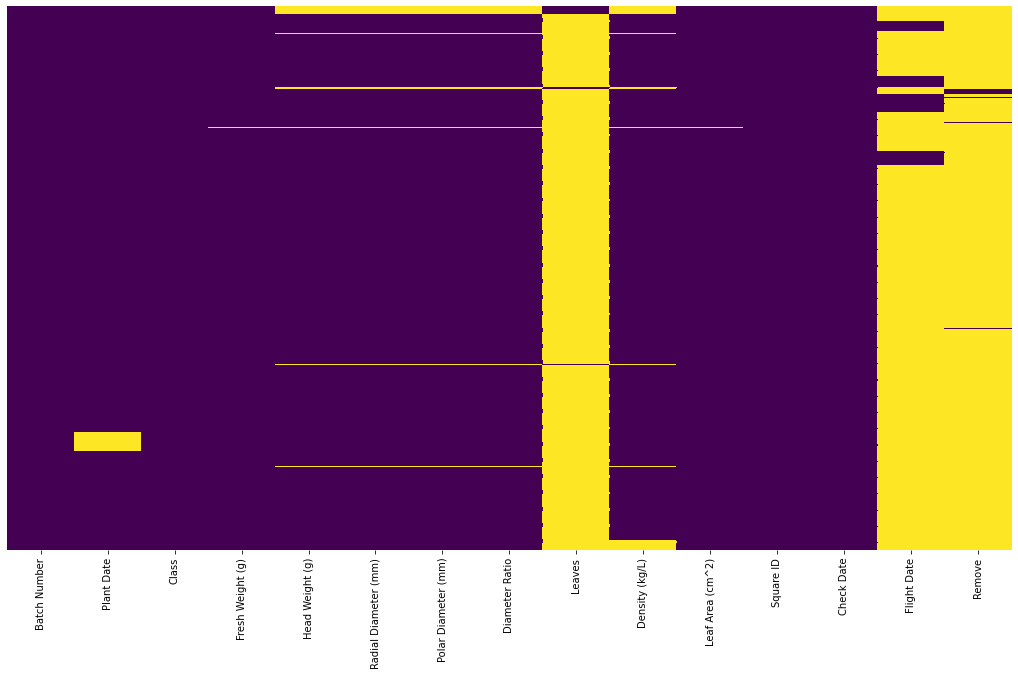

In [36]:
%matplotlib inline
plt.figure(figsize=(18,10))
sns.heatmap(new_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [37]:
new_data.dropna(subset=['Plant Date','Fresh Weight (g)',"Leaf Area (cm^2)"],inplace=True) ## removing the null values in 'Plant Date','Fresh Weight',and Leaf Area
new_data=new_data.loc[new_data['Remove'].isnull()] ## removing the rows that are not null in the Remove column

In [38]:
for columns in new_data:
    print("Null values in",columns,"=",new_data[columns].isnull().sum()) ## counting the exact null values in each columns

Null values in Batch Number = 0
Null values in Plant Date = 0
Null values in Class = 0
Null values in Fresh Weight (g) = 0
Null values in Head Weight (g) = 104
Null values in Radial Diameter (mm) = 104
Null values in Polar Diameter (mm) = 104
Null values in Diameter Ratio = 106
Null values in Leaves = 4513
Null values in Density (kg/L) = 186
Null values in Leaf Area (cm^2) = 0
Null values in Square ID = 0
Null values in Check Date = 0
Null values in Flight Date = 4145
Null values in Remove = 4613


In [39]:
null_leaves=new_data.query("Leaves != Leaves") #taking all the rows where Leaves is null
null_head_and_leaves= null_leaves.query("`Head Weight (g)` != `Head Weight (g)`") # taking all the rows where Leaves and Head weight is null


In [44]:
new_data = new_data[~new_data.isin(null_head_and_leaves)].dropna(how = 'all')

In [45]:
for columns in new_data:
    print("Null values in",columns,"=",new_data[columns].isnull().sum())

Null values in Batch Number = 0
Null values in Plant Date = 0
Null values in Class = 0
Null values in Fresh Weight (g) = 0
Null values in Head Weight (g) = 100
Null values in Radial Diameter (mm) = 100
Null values in Polar Diameter (mm) = 100
Null values in Diameter Ratio = 102
Null values in Leaves = 4509
Null values in Density (kg/L) = 182
Null values in Leaf Area (cm^2) = 0
Null values in Square ID = 0
Null values in Check Date = 0
Null values in Flight Date = 4141
Null values in Remove = 4609


We can see that Diameter Ratio and Density have extra null values but since we wont be using them for our model we can ignore them for now.

We can also observe that many flight dates are missing; Lets try to add it from the "flight_dates" data frame

In [46]:
batch_number=list(flight_dates["Batch Number"])
flight_dates_list=list(flight_dates["Flight Date"])
flight_dates_dict={}
for key in batch_number: # A dictionary with key as batch number and value as flight dates is created
    for value in flight_dates_list:
        flight_dates_dict[key] = value
        flight_dates_list.remove(value)
        break
        
for rows in range(len(new_data["Batch Number"])): # we are iterating through the batch number in new_data
    
    if pd.isnull(new_data["Flight Date"].iloc[rows]): # checking if the flight date is missing for the batch number
        if new_data["Batch Number"].iloc[rows] in flight_dates_dict.keys(): 
            
            new_data["Flight Date"].iloc[rows] = flight_dates_dict[new_data["Batch Number"].iloc[rows]] # updating the nan value in flight dates

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [47]:
for columns in new_data:
    print("Null values in",columns,"=",new_data[columns].isnull().sum())

Null values in Batch Number = 0
Null values in Plant Date = 0
Null values in Class = 0
Null values in Fresh Weight (g) = 0
Null values in Head Weight (g) = 100
Null values in Radial Diameter (mm) = 100
Null values in Polar Diameter (mm) = 100
Null values in Diameter Ratio = 102
Null values in Leaves = 4509
Null values in Density (kg/L) = 182
Null values in Leaf Area (cm^2) = 0
Null values in Square ID = 0
Null values in Check Date = 0
Null values in Flight Date = 1318
Null values in Remove = 4609


In [48]:
new_weather = processing.copy()

In [49]:
planting = planting.loc[:1820]
planting = planting.drop(["Column2","Column3","Column1","Column4"],axis=1)
planting['Plant_Date']=pd.to_datetime(planting['Plant_Date'], format='%d%b%Y:%H:%M:%S.%f')
planting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Crop            1821 non-null   object        
 1   Plant_Date      1821 non-null   datetime64[ns]
 2   Region          1821 non-null   float64       
 3   Planting_Batch  1821 non-null   object        
 4   Volume_Planted  1821 non-null   float64       
 5   Planting_Wk     1821 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 85.5+ KB


# Mearging Datas into DataFrame

In [50]:
batch_number= new_data["Batch Number"].unique()

new_data[["Crop","Region","Volume_Planted","Planting_Wk"]]=0 # adding these columns from the Planting data

for i in batch_number:
    data_to_add=planting.query("Planting_Batch == {}".format(i))
    data=new_data.query("`Batch Number`=={}".format(i))
    data["Crop"]=data_to_add["Crop"].iloc[0]
    data["Region"]=data_to_add["Region"].iloc[0]
    data["Volume_Planted"]=data_to_add["Volume_Planted"].iloc[0]
    data["Planting_Wk"]=data_to_add["Planting_Wk"].iloc[0]
    for row in data.iterrows():
        new_data.loc[row[0]]=row[1]
    
    


<ipython-input-50-6b7a29c62b2c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Crop"]=data_to_add["Crop"].iloc[0]
<ipython-input-50-6b7a29c62b2c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Region"]=data_to_add["Region"].iloc[0]
<ipython-input-50-6b7a29c62b2c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [52]:
new_data.drop(["Crop","Region"],axis=1,inplace=True)

In [53]:
new_columns=[]
for features in new_weather:
    new_columns.append(features)
    
new_columns

['Wind Speed [avg]',
 'Air Temperature [avg]',
 'Relative Humidity [avg]',
 'Dew Point [avg]',
 'ET0 [result]']

In [56]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4609 entries, 0 to 4858
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Batch Number          4609 non-null   float64       
 1   Plant Date            4609 non-null   datetime64[ns]
 2   Class                 4609 non-null   float64       
 3   Fresh Weight (g)      4609 non-null   float64       
 4   Head Weight (g)       4509 non-null   float64       
 5   Radial Diameter (mm)  4509 non-null   float64       
 6   Polar Diameter (mm)   4509 non-null   float64       
 7   Diameter Ratio        4507 non-null   float64       
 8   Leaves                100 non-null    float64       
 9   Density (kg/L)        4427 non-null   float64       
 10  Leaf Area (cm^2)      4609 non-null   float64       
 11  Square ID             4609 non-null   float64       
 12  Check Date            4609 non-null   datetime64[ns]
 13  Flight Date       

In [62]:
new_data = new_data.dropna(subset=["Head Weight (g)"])


In [68]:
new_data=new_data.dropna(subset=["Flight Date"])

new_data=new_data.drop(["Leaves","Remove"],axis=1)

In [69]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3196 entries, 75 to 3804
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Batch Number          3196 non-null   float64       
 1   Plant Date            3196 non-null   datetime64[ns]
 2   Class                 3196 non-null   float64       
 3   Fresh Weight (g)      3196 non-null   float64       
 4   Head Weight (g)       3196 non-null   float64       
 5   Radial Diameter (mm)  3196 non-null   float64       
 6   Polar Diameter (mm)   3196 non-null   float64       
 7   Diameter Ratio        3195 non-null   float64       
 8   Density (kg/L)        3195 non-null   float64       
 9   Leaf Area (cm^2)      3196 non-null   float64       
 10  Square ID             3196 non-null   float64       
 11  Check Date            3196 non-null   datetime64[ns]
 12  Flight Date           3196 non-null   datetime64[ns]
 13  Volume_Planted   

In [74]:
new_data.rename(columns={"Batch Number":"Batch","Plant Date":"Plant_Date","Fresh Weight (g)":"Fresh_Wt","Head Weight (g)":"Head_Wt","Radial Diameter (mm)":"Radial_Dia","Polar Diameter (mm)":"Polar_Dia","Leaf Area (cm^2)":"Leaf_Ar","Volume_Planted":"Quantity"},inplace=True)

In [76]:
Batch = new_data["Batch"].unique()



In [77]:
new_data.drop(["Diameter Ratio","Density (kg/L)","Square ID"],axis=1,inplace=True)

In [78]:
import datetime as dt

In [79]:
# lets calculate the number of days between each dates

new_data["Plant2check"] = (new_data["Check Date"] -new_data["Plant_Date"]).dt.days
new_data["Plant2Flight"] = (new_data["Flight Date"] -new_data["Plant_Date"]).dt.days
new_data["Flight2check"] = (new_data["Check Date"] -new_data["Flight Date"]).dt.days
new_data["Growth_on_Check"]=0

In [103]:
new_data = new_data.loc[new_data.Flight2check >= 0] # it was observed that there were some columns where checkdate was nearer that 
                                                    # flight date, we dont need those columns.

In [182]:
columns = new_weather.columns
transformed_weather = scaler.inverse_transform(new_weather)
transformed_weather = pd.DataFrame(transformed_weather)
transformed_weather.columns = columns
transformed_weather["Dates"]= new_weather.index
transformed_weather.set_index("Dates",drop=True,inplace=True)


In [194]:
plant_dates = new_data["Plant_Date"].unique()

new_data[columns] = 0

for i in plant_dates:# iterating through plant data
    
    
    print("Date = ", i)
    
    Data = new_data.loc[new_data["Plant_Date"] == i] #new datafram for i-th plant date 
    flight_dates = Data["Flight Date"].unique()
    flight_dates.sort()
   
    
    for j in flight_dates: # going through different flight dates for a plant date
        
      
        
        Flight_Data = Data.loc[new_data["Flight Date"] == j]
        check_dates = Flight_Data["Check Date"].unique()
        check_dates.sort()
        
       
        
        for k in check_dates: # going through different check dates for a perticular plant and flight date
        
            
            Check_Data = Flight_Data.loc[new_data["Check Date"] == k] # now we have a unique date
            
            if j == k: # flight date and check date are the same, we dont have to predict anything
                
                
                weather = transformed_weather[i:j]
                
    
                weather = weather.mean()
        

                weather = weather.values
            
            else:
                
                
                days = Check_Data["Flight2check"].unique()[0] 
                
                weather = transformed_weather[i:j] # getting wether till flight date
               
    
                weather = weather.values 
        

                
            
                
            
                
                result = fit_lstm(j,k,days) # predicting future weather by using weather data till flight date
                
                result = scaler.inverse_transform(result[0])
                
                weather = np.append(weather,result,0) # adding the predicted weather to the already calculated weather
                
                weather = weather.mean(axis=0)# getting mean from flight date to check date
                
                
            for c in range(len(columns)):
                
                new_data[columns[c]].loc[Check_Data.index] = weather[c] # adding the predicted data to the real data frame
                
                
                



<ipython-input-194-1b3877448704>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[columns] = 0
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Date =  2020-04-11T00:00:00.000000000
(2092, 66, 5) (2092, 22, 5)
(1674, 66, 5) (1674, 22, 5) (418, 66, 5) (418, 22, 5) (1, 66, 5)
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.30428672 0.5764778  0.8983509  0.59802604 0.36347786]
  [0.28861028 0.52625644 0.78497654 0.53185964 0.3762802 ]
  [0.30413967 0.5233339  0.7883782  0.5209019  0.37842312]
  [0.31641853 0.5271326  0.79152006 0.5190471  0.37585282]
  [0.32303756 0.5287134  0.7896841  0.5180128  0.37029853]
  [0.32701793 0.53255725 0.78977233 0.5216936  0.3664188 ]
  [0.3294546  0.5380373  0.7912312  0.52859384 0.364755  ]
  [0.3308192  0.5440321  0.79311925 0.53694    0.3

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.25737995 0.48077872 0.7756976  0.5094376  0.2998016 ]
  [0.26440364 0.5294942  0.80918026 0.55401945 0.34369734]
  [0.2636486  0.53634125 0.8026414  0.5602153  0.35486335]
  [0.26150605 0.53827626 0.79320705 0.5615906  0.36048147]
  [0.25922403 0.5397162  0.7863718  0.5629298  0.36391562]
  [0.25744596 0.5424106  0.7833961  0.5659857  0.36675227]
  [0.256

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.24735804 0.4654401  0.71436155 0.4952249  0.29401505]
  [0.26869884 0.51276666 0.7628553  0.5277635  0.34574246]
  [0.2732087  0.518333   0.7642512  0.52136666 0.35653663]
  [0.27306637 0.5182396  0.76061183 0.51512206 0.35700792]
  [0.2717809  0.52144355 0.7610016  0.5151428  0.3568404 ]
  [0.26946864 0.52598095 0.76136184 0.517957   0.3571088 ]
  [0.26685023 0.5317624  0.7620002  0.52283514 0.3585142 ]
  [0.26416558 0.53802574 0.7627796  0.52874583 0.3608174 ]
  [0.26152018 0.54410243 0.76352656 0.5348485  0.36359063]
  [0.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.26041108 0.44709653 0.72497326 0.47976086 0.30297983]
  [0.2814982  0.49685434 0.7653819  0.5156762  0.35977998]
  [0.28659806 0.4953053  0.7663772  0.5077227  0.3550249 ]
  [0.28801277 0.49963734 0.7700139  0.50731826 0.35568473]
  [0.28730065 0.50193626 0.7698827  0.5078153  0.35673478]
  [0.28675088 0.5043182  0.769859   0.50997937 0.35801345]
  [0.2869372  0.50740016 0.7709066  0.51355267 0.35960403]
  [0.28

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.263493   0.48915535 0.7958966  0.5069796  0.31439552]
  [0.26036328 0.4985713  0.8092838  0.51186705 0.35060272]
  [0.2544341  0.49812904 0.80697626 0.5114643  0.3592574 ]
  [0.24664235 0.49616143 0.799931   0.51145816 0.3590114 ]
  [0.2398862  0.4971771  0.79509    0.5151251  0.35762128]
  [0.23488805 0.501469   0.7939515  0.52252316 0.35795856]
  [0.23130947 0.50735027 0.7951308  0.531517   0.35986307]
  [0.22875041 0.5134691  0.7972013  0.5404083  0.36259553]
  [0.2

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.26077056 0.41860992 0.6867888  0.4429185  0.26034802]
  [0.29786977 0.4771024  0.7577872  0.49533045 0.3008145 ]
  [0.31283537 0.48988992 0.7644839  0.50221163 0.3117577 ]
  [0.32077885 0.49393415 0.75660026 0.5006458  0.31495473]
  [0.32576475 0.4971798  0.74750674 0.49882782 0.3151435 ]
  [0.32905445 0.5010905  0.7401669  0.49842048 0.31450543]
  [0.33143702 0.505788   0.73536885 0.4996097  0.31412163]
  [0.33323342 0.5108065  0.7327069  0.50189453 0.31426367]
  [0.33458343 0.51566964 0.7315148  0.50472903 0.3148634 ]
  [0.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.22032142 0.5071404  0.70791155 0.53262913 0.30084127]
  [0.24460134 0.57159716 0.77564174 0.5900322  0.35697016]
  [0.24197248 0.57641983 0.7810782  0.59305596 0.37462252]
  [0.23554072 0.57561827 0.7733386  0.59066725 0.38099986]
  [0.2307525  0.57821965 0.76651376 0.5916134  0.3840688 ]
  [0.22716048 0.58194685 0.76144713 0.59415233 0.38496664]
  [0.22446996 0.5857004  0.75839776 0.59727263 0.38461608]
  [0.22243506 0.5890435  0.75696224 0.60041887 0.38361916]
  [0.2

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.23736914 0.7131451  0.77869326 0.7244788  0.51569104]
  [0.22396548 0.66931266 0.7537692  0.69320256 0.48500755]
  [0.22320534 0.66680574 0.75595397 0.69821995 0.4826771 ]
  [0.22129034 0.6661521  0.76171285 0.7025831  0.47717363]
  [0.22192223 0.6687369  0.773284   0.70773757 0.47450823]]]
Date =  2020-05-19T00:00:00.000000000
(2222, 15, 5) (2222, 5, 5)
(1778, 15, 5) (1778, 5, 5) (444, 15, 5) (444, 5, 5) (1, 15, 5)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.19029152 0.75244087 0.79277307 0.7994749  0.5521509 ]
  [0.20110549 0.7182929  0.78959924 0.7547622  0.5377205 ]
  [0.20569375 0.7086379  0.7871562  0.7541571  0.54019874]
  [0.2082481  0.71203345 0.7921966  0.75328237 0.54487973]
  [0.20812918 0.7195388  0.79151714 0.758534   0.55364436]]]
Date =  2020-05-20T00:00:00.000000000
(2227, 12, 5) (2227, 4, 5)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.2561729  0.6622219  0.8345738  0.6854664  0.45817137]
  [0.25327134 0.62743723 0.80734485 0.6528368  0.44369823]
  [0.25241548 0.6245129  0.80084985 0.6516582  0.44698992]
  [0.25637278 0.6184619  0.7987727  0.64203966 0.44152898]]]
Date =  2020-05-23T00:00:00.000000000
(2223, 15, 5) (2223, 5, 5)
(

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.19931802 0.6641952  0.7746658  0.6903671  0.433519  ]
  [0.19871625 0.6694411  0.78328675 0.6985667  0.44026297]
  [0.19679216 0.6733211  0.78604823 0.7017021  0.44206047]
  [0.193946   0.673093   0.7838416  0.7004602  0.4377727 ]
  [0.19312719 0.6749864  0.78842765 0.7047478  0.43527433]]]
Date = 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.21103746 0.66347253 0.77585876 0.6711823  0.45262584]
  [0.21103987 0.6605754  0.7795069  0.6751504  0.45336   ]
  [0.20711356 0.66487443 0.77657545 0.67932487 0.45931503]
  [0.20535979 0.6598187  0.77621734 0.67405534 0.45838365]]]
Date =  2020-05-21T00:00:00.000000000
Date =  2020-06-05T00:00:00.000000000
(2169, 48, 5) (2169, 16, 5)
(1735, 48, 5) (1735, 16, 5) (434, 48, 5) (434, 16, 5) (1, 48, 5)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.23898838 0.7351112  0.87502795 0.7527077  0.46717906]
  [0.21264334 0.6977858  0.8130736  0.71321785 0.4577433 ]
  [0.20668714 0.6868513  0.80241424 0.71227103 0.4470968 ]
  [0.201343   0.68410665 0.7956058  0.71491414 0.4435336 ]
  [0.19710922 0.6852979  0.79214895 0.7183831  0.44313264]
  [0.19362602 0.6884474  0.79132307 0.7221005  0.44421542]
  [0.19052342 0.69180375 0.7915151  0.72527224 0.4451574 ]
  [0.18

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.23849666 0.694524   0.89884686 0.731973   0.41537163]
  [0.20873398 0.6574828  0.8036948  0.6945163  0.42242122]
  [0.20967762 0.6587981  0.79870087 0.69277537 0.43502608]
  [0.20710738 0.6610913  0.7898899  0.6913156  0.44108504]
  [0.20496719 0.6664397  0.7844007  0.693149   0.44758812]
  [0.20370866 0.6720254  0.7809944  0.6959883  0.45400533]
  [0.20317076 0.67650646 0.7787118  0.6986665  0.459498  ]
  [0.20

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.20155634 0.679736   0.75675356 0.6990255  0.43784386]
  [0.19607286 0.69842833 0.76883155 0.72382796 0.465245  ]
  [0.19641058 0.6898183  0.7689419  0.7129713  0.47122186]
  [0.19460948 0.68950826 0.76991206 0.7106864  0.4782194 ]
  [0.19214971 0.69001174 0.76914865 0.71055484 0.48205265]
  [0.19021739 0.6904318  0.7683385  0.7114283  0.48294425]
  [0.188

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.23344018 0.84275323 0.8879452  0.8853529  0.58132684]
  [0.20460604 0.7509366  0.7866449  0.79389024 0.54291844]
  [0.21824469 0.73495096 0.7916098  0.77723014 0.54303235]
  [0.21556748 0.738205   0.7933335  0.7812061  0.55137736]
  [0.20927195 0.74400127 0.79116935 0.78733546 0.5568041 ]
  [0.20281784 0.7505868  0.788853   0.79508406 0.5594697 ]
  [0.19729288 0.75641507 0.7874571  0.80291355 0.5596107 ]
  [0.1929916  0.7608655  0.7870499  0.8097843  0.5578157 ]
  [0.1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.1779289  0.7215218  0.80539715 0.75866354 0.44236416]
  [0.17661032 0.6919556  0.7797432  0.72139746 0.43043512]
  [0.17420721 0.6942444  0.7881312  0.72903806 0.43250474]
  [0.17321497 0.6966471  0.7865602  0.73574597 0.43625385]
  [0.17287698 0.69780785 0.78426105 0.7382576  0.4385731 ]
  [0.17256951 0.6983656  0.7825295  0.7387749  0.4393914 ]
  [0.17224798 0.6987398  0.78119814 0.7383217  0.43945304]
  [0.17188832 0.69917184 0.78011155 0.7375703  0.439191  ]
  [0.17151505 0.699714   0.77918553 0.73683935 0.43884408]
  [0.17115492 0.70033747 0.7783803  0.73624986 0.43851632]
  [0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.21786624 0.717179   0.7975791  0.73138946 0.51845276]
  [0.21883681 0.68020445 0.7587791  0.6950126  0.507098  ]
  [0.22676945 0.697512   0.77055484 0.7075102  0.5240527 ]
  [0.2294331  0.7082905  0.77985543 0.7158542  0.5339481 ]
  [0.22737604 0.71660656 0.7859496  0.72430474 0.53959924]
  [0.2228074  0.7223405  0.789071   0.731804   0.5427244 ]
  [0.216

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.19786756 0.81292903 0.79318494 0.8381848  0.5259709 ]
  [0.20375346 0.79716307 0.75335383 0.80380076 0.5407475 ]
  [0.20769323 0.7913281  0.7452558  0.7895149  0.5328283 ]
  [0.206506   0.788157   0.739529   0.78304106 0.5256163 ]
  [0.20335633 0.7880649  0.7360078  0.7812026  0.52001685]
  [0.19978382 0.78855765 0.73361194 0.78103083 0.51568985]
  [0.19655964 0.78901803 0.7320026  0.781472   0.5123842 ]
  [0.19392551 0.78934014 0.730924   0.7821032  0.5098344 ]
  [0.1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.24104625 0.71266186 0.8709312  0.76823103 0.43031418]
  [0.24198215 0.678933   0.80146873 0.73198915 0.4116934 ]
  [0.2504429  0.67992187 0.80422276 0.7327322  0.4133097 ]
  [0.2555942  0.6839243  0.8081686  0.7401061  0.41622767]
  [0.25835377 0.68807435 0.81022745 0.7475271  0.41769212]
  [0.2599503  0.6923615  0.8114606  0.75460935 0.4184525 ]
  [0.260939   0.6963094  0.8120934  0.7608141  0.41882175]
  [0.2616749  0.6996632  0.8122485  0.76582265 0.41893268]
  [0.2

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.2284391  0.93262875 1.0034618  1.0138215  0.5749085 ]
  [0.19729738 0.7923372  0.82195586 0.8432492  0.5760299 ]
  [0.20848285 0.7809006  0.8137973  0.827804   0.58028674]
  [0.20809835 0.7955171  0.81198    0.8390925  0.5920758 ]
  [0.2033475  0.8048624  0.7998543  0.8427582  0.5982295 ]
  [0.19819835 0.80966836 0.7861414  0.84390384 0.6012095 ]
  [0.19322906 0.8112999  0.77358884 0.8444484  0.6023817 ]
  [0.18

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.20171146 0.7484195  0.7498169  0.77252406 0.53777885]
  [0.19621903 0.73944056 0.73022705 0.7537313  0.56899095]
  [0.19247192 0.7661786  0.7239502  0.76749474 0.6000684 ]
  [0.186784   0.78334355 0.712747   0.7713486  0.6160951 ]
  [0.18152219 0.79251134 0.7041492  0.7717378  0.6229437 ]
  [0.17683381 0.79885864 0.69733745 0.77285874 0.62585706]
  [0.17281269 0.8033006  0.6919327  0.77489066 0.62702656]
  [0.169447   0.80636466 0.68759054 0.7774035  0.6274339 ]
  [0.1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.21889411 0.7412133  0.80414665 0.77336717 0.51050097]
  [0.2216408  0.6978517  0.7793585  0.7450783  0.5045196 ]
  [0.22084069 0.70933616 0.7877221  0.7547654  0.518387  ]
  [0.21518902 0.7163365  0.7844162  0.75784254 0.52257293]
  [0.20889914 0.7202018  0.7777661  0.75794977 0.5221053 ]
  [0.20359004 0.7234449  0.77251756 0.75886416 0.5210121 ]
  [0.19934843 0.7263986  0.769111   0.7607417  0.520031  ]
  [0.19

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.22383076 0.7183732  0.8531011  0.749353   0.44489756]
  [0.21151885 0.69972974 0.8210406  0.72821414 0.4427712 ]
  [0.215496   0.6912626  0.81845874 0.71888626 0.4410123 ]
  [0.21770746 0.685779   0.8168351  0.716241   0.43942168]
  [0.2188592  0.68708354 0.82055086 0.7217258  0.44020712]
  [0.21741584 0.69321156 0.8248113  0.73140824 0.44347367]
  [0.21456388 0.6990963  0.82698256 0.74001265 0.44633278]
  [0.21

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1291: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


[[[nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]]]
(2236, 15, 5) (2236, 5, 5)
(1789, 15, 5) (1789, 5, 5) (447, 15, 5) (447, 5, 5) (1, 15, 5)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.22677353 0.6760617  0.85568595 0.7275753  0.40050855]
  [0.2246286  0.6593204  0.8354883  0.70448864 0.38547018]
  [0.22364068 0.66192466 0.83925104 0.7054626  0.38968703]
  [0.22299457 0.66137165 0.84083116 0.705581   0.38574353]
  [0.223172   0.6631982  0.8451662  0.7109704  0.3828391 ]]]
Date = 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.23548675 0.5817042  0.7952251  0.6089051  0.35769853]
  [0.23219275 0.5796892  0.7949117  0.60740525 0.3557185 ]
  [0.22799349 0.5821964  0.7975598  0.61269593 0.35885075]
  [0.221649

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.17628998 0.6724763  0.73206276 0.69505876 0.40720814]
  [0.18849541 0.6810094  0.7667535  0.70737964 0.4174849 ]
  [0.19791292 0.68309474 0.78445905 0.7111018  0.41864938]
  [0.20306371 0.68370354 0.7901046  0.711863   0.4188075 ]
  [0.20606878 0.6862562  0.7916727  0.71311015 0.4192685 ]
  [0.20787977 0.6897806  0.79145104 0.7145798  0.41953528]
  [0.20908324 0.69338393 0.79061925 0.7159825  0.41942546]
  [0.2099895  0.69660056 0.78976476 0.7171816  0.41898757]
  [0.21074934 0.6992723  0.7891274  0.71814036 0.41834635]
  [0.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.19945036 0.7260262  0.833047   0.76676416 0.45585158]
  [0.19295977 0.6994909  0.81810987 0.74581087 0.438465  ]
  [0.1817891  0.7017517  0.81982327 0.7515748  0.44192323]
  [0.18055066 0.70400524 0.8280178  0.7586374  0.43513367]]]
(2210, 33, 5) (2210, 11, 5)
(1768, 33, 5) (1768, 11, 5) (442, 33, 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.18128252 0.7057023  0.7358972  0.71641195 0.44384256]
  [0.18195854 0.7006688  0.73526603 0.7151688  0.4423696 ]
  [0.1777875  0.7049325  0.73104966 0.71684015 0.4443702 ]
  [0.17273761 0.7117746  0.729702   0.72234535 0.44978055]
  [0.16974123 0.71590257 0.7287879  0.7253529  0.4510558 ]
  [0.16823004 0.7191409  0.72877026 0.727814   0.45138445]
  [0.16740642 0.72166157 0.72907424 0.72988856 0.4514241 ]
  [0.16683422 0.723694   0.72947526 0.73173463 0.4514156 ]
  [0.1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.22499563 0.69263786 0.7803989  0.7073538  0.46003377]
  [0.22570843 0.6748472  0.77347225 0.6956398  0.4497606 ]
  [0.22421876 0.6842168  0.7753004  0.7029988  0.45130533]
  [0.22660403 0.6788002  0.77034605 0.6969195  0.44963312]]]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


(2210, 33, 5) (2210, 11, 5)
(1768, 33, 5) (1768, 11, 5) (442, 33, 5) (442, 11, 5) (1, 33, 5)
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.19529217 0.68567634 0.7731063  0.69912225 0.4388165 ]
  [0.20280296 0.6748617  0.7792366  0.677247   0.43483096]
  [0.20658134 0.68057567 0.7964824  0.68220717 0.4257643 ]
  [0.20922212 0.6823321  0.80221575 0.68400097 0.42150658]
  [0.21150608 0.6831638  0.8045874  0.6848437  0.41853514]
  [0.21280318 0.6839226  0.8056912  0.68498415 0.41505933]
  [0.21333975 0.68505746 0.8066

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.21944697 0.68576396 0.8217608  0.7226164  0.42366698]
  [0.20858124 0.6716309  0.7939435  0.70367336 0.4160243 ]
  [0.20488216 0.67784756 0.80012137 0.7136397  0.41855603]
  [0.19780497 0.6763672  0.8016238  0.7153238  0.41723213]
  [0.19400646 0.6778949  0.80293536 0.7192045  0.41733962]
  [0.19268715 0.68035567 0.80274683 0.72353697 0.41652483]
  [0.19284342 0.68297786 0.801643   0.7274994  0.41470897]]]
(2190

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.18389416 0.8298364  0.79562944 0.8481681  0.53825366]
  [0.20875256 0.7569137  0.7716932  0.7871725  0.5475764 ]
  [0.22679293 0.7399773  0.77662796 0.78304607 0.56795466]
  [0.24302132 0.73857284 0.7799844  0.7840454  0.5861952 ]
  [0.25519955 0.7383328  0.7796894  0.78505033 0.5967544 ]
  [0.26402226 0.73962295 0.7785095  0.7866604  0.6016404 ]
  [0.27034807 0.74156463 0.77698964 0.7882694  0.60297424]
  [0.274919   0.7437083  0.7756308  0.7896231  0.6023468 ]
  [0.2

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.18712349 0.6651748  0.74755436 0.6659445  0.43419883]
  [0.18108046 0.67226785 0.757013   0.67250603 0.43512255]
  [0.1793065  0.6780357  0.7647845  0.6778258  0.4394553 ]
  [0.17626494 0.6774868  0.7634011  0.6762717  0.43963224]
  [0.17287746 0.67794126 0.7630387  0.67773396 0.439295  ]
  [0.16987431 0.6791291  0.7640733  0.6811748  0.43874255]]]
(2229, 30, 5) (2229, 10, 5)
(1783, 30, 5) (1783, 10, 5) (446, 30

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.20390156 0.7587171  0.81905067 0.78292495 0.48894656]
  [0.18901959 0.71308386 0.7767588  0.74482673 0.47047853]
  [0.18312182 0.7235412  0.7943089  0.76124597 0.476224  ]
  [0.17829882 0.720113   0.7937101  0.7639511  0.46928763]
  [0.17472538 0.7204891  0.7937193  0.76768494 0.46381062]
  [0.17172024 0.720837   0.7933878  0.76950705 0.45961583]
  [0.16930859 0.7215411  0.79376423 0.77043074 0.4571063 ]
  [0.16740444 0.72225684 0.7946262  0.7707034  0.45579636]
  [0.16593024 0.7229063  0.795784   0.77062434 0.45526117]
  [0.16479957 0.72344136 0.79704356 0.77036107 0.45515993]]]
Da

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.2058631  0.7256485  0.75826234 0.72541314 0.5374894 ]
  [0.19443081 0.70836425 0.7513462  0.7113529  0.5195991 ]
  [0.19390127 0.71576196 0.7601559  0.7192733  0.5228568 ]
  [0.19292627 0.7153318  0.7608127  0.71692437 0.5207092 ]
  [0.19331115 0.71635324 0.7630584  0.7143571  0.51946294]
  [0.1939

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.1790959  0.7070325  0.7725923  0.7332372  0.44133002]
  [0.17768979 0.7043851  0.7763592  0.72910064 0.43111467]
  [0.18005106 0.71196395 0.78046155 0.7358865  0.42580146]
  [0.18036526 0.7123975  0.77974105 0.73657554 0.42353365]
  [0.17973131 0.71180993 0.7796434  0.73532826 0.42238533]
  [0.1782003  0.7118805  0.7798617  0.7333552  0.42165804]
  [0.17642823 0.7123764  0.78035414 0.7311971  0.42114955]]]
(2229

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.20293604 0.72825557 0.80728143 0.7578782  0.47249612]
  [0.197549   0.70028585 0.7799778  0.7225414  0.47390836]
  [0.20312408 0.7101592  0.77990013 0.7294052  0.4842365 ]
  [0.205572   0.70895684 0.7774373  0.72764283 0.4813405 ]
  [0.20612824 0.7077916  0.7761228  0.72846603 0.47870174]
  [0.20613728 0.7075716  0.7756404  0.7309633  0.4770433 ]
  [0.20605548 0.70813334 0.7754127  0.7342084  0.47628018]
  [0.20

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.22640695 0.7325427  0.8227898  0.773418   0.46304706]
  [0.24261038 0.6873036  0.7841267  0.7281549  0.45973644]
  [0.25513566 0.6779898  0.7824035  0.71961653 0.46268746]
  [0.26231733 0.6785788  0.78660023 0.72184324 0.46240437]
  [0.2658488  0.6769805  0.7871053  0.72182554 0.4568313 ]
  [0.26832396 0.67653817 0.78955114 0.72343725 0.45050636]
  [0.26981264 0.67578673 0.7924636  0.7254744  0.44411644]
  [0.27044892 0.6744222  0.7951788  0.7274268  0.43791345]
  [0.27041066 0.672515   0.79732156 0.72902745 0.43197957]
  [0.26989707 0.6702494  0.7987658  0.73019403 0.4263273 ]
  [0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.21283425 0.80379957 0.80055153 0.8052857  0.54576266]
  [0.20955382 0.78883606 0.75770104 0.8025537  0.5790737 ]
  [0.21339884 0.79220384 0.76096135 0.8183601  0.5850807 ]
  [0.21398565 0.7872953  0.75343716 0.81812406 0.5807238 ]
  [0.21561305 0.784795   0.7518508  0.8169043  0.5764211 ]
  [0.21821755 0.7836537  0.75364333 0.815568   0.5707392 ]
  [0.22118196 0.7830152  0.7566669  0.81413686 0.5639097 ]
  [0.2240789  0.7823493  0.7597087  0.8125707  0.55636555]
  [0.2

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.18519098 0.74046916 0.80026937 0.7621519  0.4591556 ]
  [0.17840777 0.7217253  0.75716484 0.7322805  0.47779733]
  [0.1884739  0.7194388  0.7648313  0.7319108  0.47205204]
  [0.18782713 0.71558124 0.7655922  0.7328301  0.46522927]
  [0.18450877 0.7140742  0.7646999  0.73456186 0.4595518 ]
  [0.18131043 0.7139878  0.7634704  0.73596793 0.45536792]
  [0.17882788 0.7139574  0.76168346 0.735975   0.45171595]
  [0.17

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.1700603  0.74899375 0.7858687  0.7753756  0.52336   ]
  [0.16695648 0.7148924  0.766681   0.7532878  0.50895303]
  [0.16206473 0.72452736 0.7719419  0.76858425 0.5175055 ]
  [0.1593011  0.727739   0.7720849  0.77421916 0.5142469 ]
  [0.15962249 0.72941875 0.774423   0.7788043  0.507745  ]
  [0.1602

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.19057448 0.7180823  0.8105195  0.75207645 0.4286858 ]
  [0.18383873 0.7138926  0.78827006 0.7335687  0.43414858]
  [0.18535519 0.72170913 0.79204005 0.74115103 0.44063443]
  [0.18601541 0.7224815  0.7917091  0.74082935 0.43976355]
  [0.18665966 0.7226627  0.79151046 0.73975426 0.43681872]
  [0.18689886 0.7232598  0.79172665 0.7393828  0.43390343]
  [0.18677999 0.724016   0.79213995 0.7396691  0.43154028]
  [0.18639186 0.72466946 0.7925841  0.7403493  0.42973572]
  [0.18583733 0.7251186  0.7929962  0.7412105  0.42838562]
  [0.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.17745945 0.74289817 0.7938167  0.75000805 0.5658835 ]
  [0.17388186 0.7259262  0.78557277 0.73838764 0.55563027]
  [0.16241798 0.7232811  0.7771958  0.7341746  0.55748564]
  [0.1605886  0.724703   0.7817471  0.7364307  0.5556099 ]
  [0.15817472 0.7243629  0.7836013  0.7370504  0.5515917 ]
  [0.15579218 0.724769   0.7854992  0.73797894 0.54855424]
  [0.15320206 0.7250221  0.7867944  0.7386349  0.54607767]
  [0.15053931 0.72502655 0.7875055  0.7390104  0.5440964 ]
  [0.14800043 0.72479516 0.78776467 0.7391582  0.54250675]]]
(22

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.18350402 0.6972882  0.73489064 0.71396434 0.4588938 ]
  [0.19046712 0.70002    0.7280144  0.7133583  0.4734883 ]
  [0.19133468 0.7037097  0.7249519  0.7110812  0.4775189 ]
  [0.19124058 0.7063613  0.71951944 0.7121433  0.48301518]
  [0.19022879 0.70788985 0.71544355 0.7116618  0.48347878]
  [0.18888997 0.7100231  0.7135704  0.7115818  0.48287836]
  [0.18764476 0.7123973  0.71298087 0.7115943  0.48184934]
  [0.1866444  0.71471506 0.71306854 0.7115486  0.48074692]
  [0.18590467 0.71680343 0.7134575  0.71138334 0.47971198]
  [0.18538523 0.7186074  0.7139508  0.7111077  0.47879615]
  [0.18503222 0.72013575 0.71445477 0.7107593  0.47801155]
  [

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.19144887 0.7363284  0.7399761  0.7387535  0.5043171 ]
  [0.1737383  0.73645353 0.74499184 0.73999923 0.49265563]
  [0.16424212 0.74201924 0.7394477  0.74292845 0.48165393]
  [0.15756059 0.7460192  0.74737    0.74623436 0.4745071 ]
  [0.15299019 0.7486895  0.75339705 0.7479482  0.46954766]
  [0.1497

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.17296168 0.79186314 0.8044342  0.81640375 0.5050911 ]
  [0.16652432 0.7526987  0.76558155 0.7727864  0.48566997]
  [0.16392738 0.7542746  0.76560163 0.7738129  0.4874053 ]
  [0.16263849 0.75583684 0.7648378  0.77424663 0.4846381 ]
  [0.16127539 0.7587405  0.7646322  0.77693045 0.48224705]
  [0.15955621 0.7615152  0.7648531  0.78081566 0.4800282 ]
  [0.1575787  0.7633817  0.7651938  0.7846447  0.47773182]
  [0.15552199 0.76437044 0.76559794 0.78779733 0.47533178]
  [0.15349293 0.7648003  0.76609325 0.7901695  0.47292024]
  [0.15155944 0.76495135 0.7666985  0.791858   0.47058606]
  [0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.21029064 0.71465594 0.782643   0.7175487  0.5058644 ]
  [0.1917612  0.688127   0.76343626 0.6997759  0.50046885]
  [0.19511485 0.6894701  0.76946294 0.70535654 0.5069079 ]
  [0.19533539 0.69127315 0.76568013 0.7045405  0.50099856]
  [0.19259173 0.69864464 0.76324266 0.7074907  0.49562755]
  [0.1878

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.16878356 0.64815384 0.70478106 0.659825   0.44306284]
  [0.1623064  0.69352263 0.7211553  0.6973662  0.482553  ]
  [0.15773463 0.7040724  0.7188761  0.70104945 0.48752066]
  [0.15198994 0.7039485  0.71243644 0.6976802  0.48563588]
  [0.14778338 0.7048779  0.70827687 0.69606656 0.48365107]
  [0.14550355 0.7069906  0.7058358  0.6961422  0.48193407]
  [0.14473324 0.70963365 0.7044034  0.69726825 0.4805634 ]
  [0.14494748 0.7122577  0.70355964 0.6988459  0.47953448]
  [0.14571664 0.7145832  0.7030864  0.7004948  0.47881064]]]
(2229, 36, 5) (2229, 12, 5)
(1783, 36, 5) (1783, 12, 5) (446, 36, 5) (446, 12, 5) (1, 36, 5)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.18025522 0.75273925 0.7949259  0.76810044 0.50383055]
  [0.17215718 0.7402044  0.7870204  0.754891   0.5066716 ]
  [0.17826164 0.7370641  0.7979393  0.7575209  0.50866103]
  [0.1760421  0.73881495 0.79828244 0.76067924 0.51033854]
  [0.17289904 0.7418075  0.7983928  0.7627089  0.5113192 ]
  [0.17091697 0.7437952  0.80051535 0.7639743  0.5120031 ]
  [0.1700341  0.74420893 0.8041026  0.76447856 0.5119704 ]
  [0.16990563 0.74341065 0.80854785 0.7646135  0.5111245 ]
  [0.1702012  0.7419335  0.8133438  0.76466674 0.5095389 ]
  [0.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.18553792 0.7792241  0.7577604  0.7751602  0.5440624 ]
  [0.1971134  0.7505693  0.7395067  0.74390954 0.5256575 ]
  [0.20540963 0.7461696  0.7449708  0.74322015 0.52309644]
  [0.20804103 0.7449532  0.7430444  0.7431184  0.5215178 ]
  [0.21029025 0.7462663  0.74047244 0.7453479  0.52021044]
  [0.21175607 0.7492984  0.73832995 0.748777   0.51944214]
  [0.212

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.19422384 0.75398487 0.74622893 0.7665406  0.5223927 ]
  [0.20750076 0.7243758  0.75695616 0.742572   0.5122227 ]
  [0.21597789 0.7167348  0.76940995 0.731852   0.5164437 ]
  [0.2194346  0.7155719  0.7698224  0.72505933 0.5207001 ]
  [0.22112194 0.71594596 0.7667712  0.72107166 0.52159065]
  [0.22279872 0.71683115 0.7633973  0.7194181  0.5208771 ]
  [0.22475229 0.71780884 0.760357   0.71922475 0.519525  ]
  [0.22

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.2143877  0.7499843  0.821347   0.7632112  0.47202215]
  [0.21073085 0.71535766 0.7913806  0.7282181  0.44577292]
  [0.21078281 0.7156295  0.78691053 0.73204076 0.44187707]
  [0.21449104 0.71299595 0.7895472  0.7333518  0.43591532]
  [0.21808219 0.70976263 0.79259884 0.7334685  0.42976534]
  [0.22050232 0.70861995 0.79530656 0.73382694 0.4257313 ]]]
(2236, 36, 5) (2236, 12, 5)
(1789, 36, 5) (1789, 12, 5) (447, 36

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.18937138 0.7060479  0.7724838  0.7270483  0.46785736]
  [0.19645382 0.6935302  0.7575295  0.7172833  0.46312904]
  [0.20104793 0.700793   0.7607217  0.7162818  0.46211368]
  [0.20371635 0.7069996  0.7585242  0.7228279  0.46264213]
  [0.20559645 0.70955175 0.7559181  0.7285074  0.46212888]
  [0.20719264 0.7110162  0.75463384 0.7329297  0.4612381 ]
  [0.20846069 0.71228945 0.754401   0.736408   0.4602601 ]
  [0.20943163 0.713694   0.75485617 0.7393189  0.45935225]
  [0.21015298 0.7152865  0.7556912  0.74189514 0.45859176]
  [0.21067017 0.71701014 0.75668097 0.7442437  0.45800155]
  [0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.18518189 0.7223283  0.7635833  0.7352838  0.47486186]
  [0.18167196 0.72517043 0.7681028  0.73636967 0.47256923]
  [0.17531237 0.7290793  0.7624609  0.7340205  0.47785598]
  [0.17091079 0.73122555 0.75665104 0.7351259  0.47402292]
  [0.16922069 0.73262376 0.75363356 0.7372776  0.4687904 ]
  [0.1693678  0.73446435 0.7533724  0.74045134 0.46464866]]]
(2241, 33, 5) (2241, 11, 5)
(1793, 33, 5) (1793, 11, 5) (448, 33

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.18092029 0.81246907 0.81509715 0.8330879  0.52139497]
  [0.18989612 0.76472634 0.7855713  0.7863015  0.48671404]
  [0.19441167 0.7635763  0.7929966  0.78417027 0.479403  ]
  [0.19361709 0.7579639  0.7899807  0.7795111  0.47184205]
  [0.19246541 0.7544639  0.7899762  0.77811944 0.4672304 ]
  [0.19180644 0.7531976  0.7923283  0.7788278  0.46571323]
  [0.19163117 0.75305253 0.79536515 0.78027654 0.46596023]
  [0.19

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.17112997 0.741461   0.76339847 0.7330856  0.4839406 ]
  [0.14929119 0.75416785 0.75945634 0.74630165 0.47505856]
  [0.14380899 0.76356465 0.7578691  0.7542661  0.47108623]
  [0.14596313 0.7678194  0.7619574  0.7539782  0.46216404]
  [0.14395109 0.7644045  0.76041836 0.75250775 0.45129308]
  [0.14045735 0.7595493  0.75821275 0.7514495  0.44289535]]]
(2236, 36, 5) (2236, 12, 5)
(1789, 36, 5) (1789, 12, 5) (447, 36, 5) (447, 12, 5) (1, 36, 5)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.18942532 0.74237436 0.7784419  0.75730306 0.47911742]
  [0.19294605 0.7057788  0.76238906 0.72595304 0.46588203]
  [0.19875103 0.71273416 0.771909   0.73127955 0.464587  ]
  [0.19763094 0.7138747  0.76796544 0.7309123  0.458106  ]
  [0.19541526 0.7151987  0.7652482  0.73129743 0.4540325 ]
  [0.19392157 0.7167483  0.76395714 0.73191994 0.4519331 ]
  [0.19337386 0.718276   0.76365113 0.73245955 0.45090494]
  [0.19

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.17642136 0.78641623 0.7549383  0.787325   0.50548375]
  [0.17128868 0.7839035  0.76714724 0.7842259  0.5013062 ]
  [0.16368362 0.78006923 0.7743021  0.78399235 0.49054834]
  [0.16339876 0.7763272  0.7817397  0.7812344  0.4817529 ]
  [0.16535452 0.77452415 0.7876696  0.7787109  0.47895923]
  [0.16686806 0.7744092  0.7914474  0.77823657 0.4808931 ]]]
(2241, 33, 5) (2241, 11, 5)
(1793, 33, 5) (1793, 11, 5) (448, 33

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.1687936  0.70282394 0.74142426 0.7232125  0.44955257]
  [0.16562246 0.7284341  0.7539012  0.73718953 0.48851934]
  [0.1626892  0.71520567 0.76075965 0.7297496  0.49673563]
  [0.15932535 0.70040214 0.7605389  0.7193644  0.49826175]
  [0.15680681 0.68891156 0.76014704 0.71113235 0.49723575]
  [0.1548867  0.68317866 0.760833   0.70752203 0.4964098 ]
  [0.15340078 0.6806611  0.7620632  0.70642775 0.49531147]
  [0.15220039 0.67980754 0.76328677 0.70654166 0.49383855]
  [0.15122148 0.6797686  0.7642725  0.70715296 0.49211738]
  [0.15044078 0.68008953 0.7649663  0.7078892  0.49031666]
  [0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.19772369 0.74486876 0.76425207 0.7843083  0.49719658]
  [0.22467387 0.7079496  0.76425195 0.74886435 0.49134234]
  [0.24326436 0.70967406 0.77730095 0.7487768  0.49794897]
  [0.24980402 0.70721394 0.7820618  0.7456917  0.4945384 ]
  [0.25452784 0.707215   0.7879534  0.7466243  0.4929709 ]
  [0.2593

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.2023714  0.7008608  0.83927256 0.768112   0.37570116]
  [0.21988337 0.6568235  0.8214399  0.7146296  0.3363479 ]
  [0.23128645 0.65835136 0.8462716  0.7209499  0.3310523 ]
  [0.23956631 0.6525735  0.85615325 0.7201344  0.32656994]
  [0.24581747 0.649619   0.8630367  0.7201972  0.3246128 ]
  [0.24975203 0.6482653  0.86762327 0.7217838  0.3229928 ]
  [0.25174984 0.64736676 0.8700984  0.72382355 0.32094923]
  [0.25

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.2551625  0.5879497  0.869321   0.65940595 0.30313757]
  [0.25837007 0.5767353  0.8429406  0.64798605 0.30388087]
  [0.26199493 0.5807193  0.83571666 0.65517914 0.3117854 ]]]
Date =  2020-07-21T00:00:00.000000000
(2275, 18, 5) (2275, 6, 5)
(1820, 18, 5) (1820, 6, 5) (455, 18, 5) (455, 6, 5) (1, 18, 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.18726829 0.6522308  0.7932207  0.7033585  0.31243336]
  [0.21161513 0.6522853  0.8194235  0.69852406 0.32813016]
  [0.22629747 0.6506417  0.8304302  0.6974736  0.33490166]
  [0.2371429  0.6465797  0.8354526  0.69170576 0.3373262 ]
  [0.2440194  0.6455179  0.84133416 0.6887661  0.3396585 ]
  [0.2477

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.1624173  0.7484858  0.74899685 0.80039924 0.46144962]
  [0.18935254 0.72889435 0.76603025 0.78354543 0.45823267]
  [0.20509297 0.72097784 0.7707259  0.77409416 0.4583402 ]
  [0.21190348 0.71624947 0.772885   0.7688698  0.45625985]
  [0.21825296 0.7159666  0.77645147 0.76758975 0.4567081 ]
  [0.22397035 0.717114   0.7789092  0.7666279  0.4588925 ]
  [0.229

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.21776718 0.61840653 0.8588162  0.6901716  0.31313908]
  [0.22211759 0.60613334 0.8599435  0.6744867  0.30233717]
  [0.21559435 0.6030106  0.86713207 0.67147607 0.29646045]
  [0.21926643 0.59836227 0.8760848  0.6680328  0.29560566]
  [0.22062616 0.5932285  0.8777979  0.66268224 0.2946589 ]
  [0.22231427 0.5897852  0.87958616 0.65934956 0.29436368]]]
(2284, 21, 5) (2284, 7, 5)
(1827, 21, 5) (1827, 7, 5) (457, 21, 5) (457, 7, 5) (1, 21, 5)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.23450115 0.6094622  0.87316334 0.6726255  0.3204028 ]
  [0.23552427 0.59940314 0.8606112  0.6613581  0.31189457]
  [0.23926702 0.6044156  0.867273   0.6692517  0.3145784 ]
  [0.24294472 0.5950535  0.86490583 0.66291094 0.30614647]
  [0.245202   0.59173155 0.8660713  0.66110003 0.3021075 ]
  [0.24687484 0.59088516 0.8681348  0.6610213  0.29977757]
  [0.24800053 0.5915014  0.8702067  0.66202164 0.29875907]]]
(2252

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.1986059  0.7018601  0.90747625 0.7708308  0.27264196]
  [0.21658078 0.6444     0.87586945 0.7207881  0.2519235 ]
  [0.23851389 0.6270159  0.8890192  0.7111141  0.25265327]
  [0.2512181  0.6115483  0.89349645 0.7015561  0.24939907]
  [0.25998047 0.6019184  0.89768803 0.6968647  0.2458287 ]
  [0.2662285  0.5957063  0.90100974 0.69453555 0.24237858]
  [0.27074686 0.59148645 0.903287   0.69311833 0.23931558]
  [0.2740238  0.58849883 0.90467787 0.6919996  0.23678215]
  [0.2

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.22911395 0.65175176 0.9008812  0.72263974 0.35573474]
  [0.21783309 0.6294242  0.8645009  0.69477105 0.34628996]
  [0.2194445  0.6346561  0.87520385 0.700088   0.35525393]
  [0.21676037 0.6314961  0.87774813 0.69777524 0.3541415 ]
  [0.21550316 0.63075364 0.8835868  0.6970686  0.3532299 ]
  [0.21485326 0.6315727  0.89003086 0.69728637 0.3529196 ]]]
(2285, 21, 5) (2285, 7, 5)
(1828, 21, 5) (1828, 7, 5) (457, 21, 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
INFO:tensorflow:Assets written to: /tmp\checkpoint\assets
[[[0.23220934 0.5914863  0.86048806 0.65468323 0.2681008 ]
  [0.23786797 0.58253044 0.848034   0.64775383 0.25467548]
  [0.24607408 0.581401   0.8636175  0.64968693 0.2505594 ]
  [0.25225273 0.572294   0.8654533  0.6437141  0.24787058]
  [0.25759217 0.56878763 0.87027234 0.64234936 0.24815205]
  [0.2619959  0.5679993  0.875404   0.64245796 0.24925688]
  [0.2657576  0.5681831  0.8799754  0.6427441  0.2504009 ]]]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


PermissionError: [Errno 13] Permission denied: 'new_data.csv'

In [220]:
# Now lets compare the predicted data with the real one. So lets calulate the real average weather


temp_new_data = new_data.copy()    


temp_new_data[columns] = 0

for i in plant_dates:
    
    
    print("Date = ", i)
    
    Data = temp_new_data.loc[temp_new_data["Plant_Date"] == i]
    flight_dates = Data["Flight Date"].unique()
    flight_dates.sort()
   
    
    for j in flight_dates:
        
      #  print("Flight_date now j",j)
        
        Flight_Data = Data.loc[temp_new_data["Flight Date"] == j]
        check_dates = Flight_Data["Check Date"].unique()
        check_dates.sort()
        
       # print("Check dates are", check_dates)
        
        for k in check_dates:
            
         #   print("check_dates now = (k) ", k )
            
            Check_Data = Flight_Data.loc[temp_new_data["Check Date"] == k]
            
            if j == k:
                
                
                weather = transformed_weather[i:k]
                
    
                weather = weather.mean()
        

                weather = weather.values
                              
            for c in range(len(columns)):
                
                temp_new_data[columns[c]].loc[Check_Data.index] = weather[c]    


Date =  2020-04-11T00:00:00.000000000
Date =  2020-04-15T00:00:00.000000000
Date =  2020-04-16T00:00:00.000000000
Date =  2020-05-18T00:00:00.000000000
Date =  2020-05-19T00:00:00.000000000
Date =  2020-05-20T00:00:00.000000000
Date =  2020-05-23T00:00:00.000000000
Date =  2020-05-22T00:00:00.000000000
Date =  2020-05-21T00:00:00.000000000
Date =  2020-06-05T00:00:00.000000000
Date =  2020-06-03T00:00:00.000000000
Date =  2020-06-06T00:00:00.000000000
Date =  2020-06-04T00:00:00.000000000
Date =  2020-06-15T00:00:00.000000000
Date =  2020-06-13T00:00:00.000000000
Date =  2020-06-12T00:00:00.000000000
Date =  2020-06-11T00:00:00.000000000
Date =  2020-06-25T00:00:00.000000000
Date =  2020-06-26T00:00:00.000000000


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Date =  2020-06-30T00:00:00.000000000
Date =  2020-07-01T00:00:00.000000000
Date =  2020-06-29T00:00:00.000000000
Date =  2020-07-06T00:00:00.000000000
Date =  2020-07-04T00:00:00.000000000
Date =  2020-07-07T00:00:00.000000000
Date =  2020-07-11T00:00:00.000000000
Date =  2020-07-10T00:00:00.000000000
Date =  2020-07-12T00:00:00.000000000
Date =  2020-07-20T00:00:00.000000000
Date =  2020-07-21T00:00:00.000000000
Date =  2020-08-06T00:00:00.000000000
Date =  2020-08-08T00:00:00.000000000


now lets compare this with original weather data

In [221]:
predicted_weather=new_data[["Wind Speed [avg]","Air Temperature [avg]","Relative Humidity [avg]","Dew Point [avg]","ET0 [result]"]]

In [222]:
index = new_data.loc[new_data["Wind Speed [avg]"] == new_data["Wind Speed [avg]"] ].index

In [223]:
real_weather=temp_new_data[["Wind Speed [avg]","Air Temperature [avg]","Relative Humidity [avg]","Dew Point [avg]","ET0 [result]"]]

In [224]:
real_weather =real_weather.loc[index]

In [225]:
predicted_weather = predicted_weather.loc[index]

Wind Speed [avg]


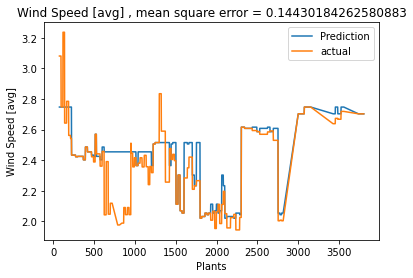

error of total mean 0.05741589337525044
Air Temperature [avg]


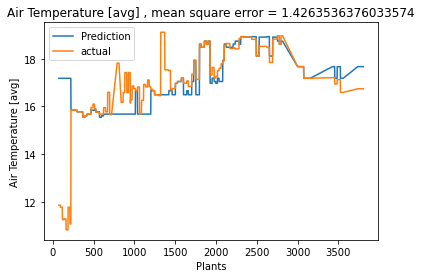

error of total mean 0.08984917473113896
Relative Humidity [avg]


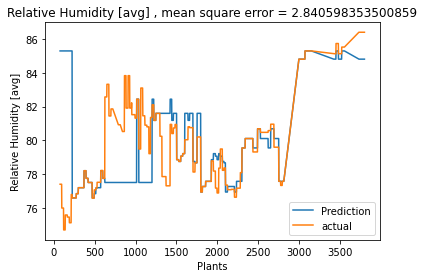

error of total mean 0.055738526286646106
Dew Point [avg]


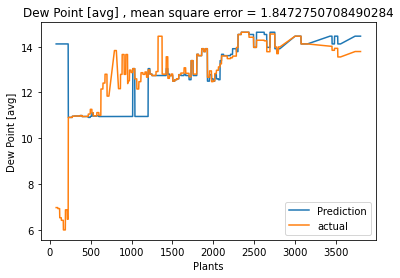

error of total mean 0.10995281901356968
ET0 [result]


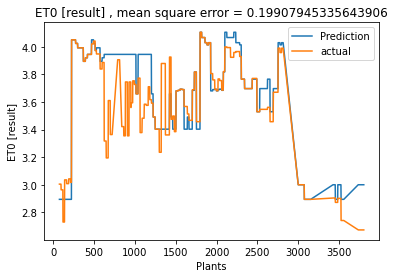

error of total mean 0.07029370752335407


In [230]:

# plotting the graph

for i in predicted_weather.columns:
    print(i)
    r2=mean_squared_error(real_weather[i],predicted_weather[i])
    mse = math.sqrt(r2)
    plt.title("{} , mean square error = {}".format(i,mse))
    plt.xlabel("Plants")
    plt.ylabel("{}".format(i))
    plt.plot(real_weather[i])
    plt.plot(predicted_weather[i])
    
    
    plt.legend(["Prediction","actual"])
    
    plt.show()
    
    error = abs(real_weather[i].mean()-predicted_weather[i].mean())
    print("error of total mean",error)
    

In [228]:
new_data = new_data.loc[index]

In [229]:
new_data.to_csv("new_data.csv")   ## lets save the derived dataframe.